In [1]:
# Install TA-lib and, ccxt, optuna
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%pip install Ta-Lib
%pip install ccxt
%pip install optuna

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the repository
repo_path = '/content/drive/MyDrive/tradingBot'
%cd {repo_path}

# Pull the latest changes
!git pull origin main

UsageError: Line magic function `%wget` not found.


In [1]:
from model_utils import CryptoDataset, check_for_missing_data, normalize_data, create_targets, create_features, feature_cut, profitable_percent, distribution, pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from optuna.pruners import SuccessiveHalvingPruner
import numpy as np

2024-12-30 00:32:44.262760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735543964.323034  294815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735543964.341143  294815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 00:32:44.411479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please

In [2]:
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list your GPU


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

# Objective function for optimization
def objective(trial):

    # MODEL CREATION
    params_grid = {
        # LSTM Units
        "lstm_units_1": trial.suggest_categorical("lstm_units_1", [64, 128, 256]),
        "lstm_units_2": trial.suggest_categorical("lstm_units_2", [32, 64, 128]),

        # Dropout rate for regularization
        "dropout": trial.suggest_categorical("dropout", [0.1, 0.2, 0.3, 0.5]),

        # Learning rate for the optimizer (log scale for better range)
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),

        # Batch size (common choices)
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),

        # Dense layer units (for fully connected layers after LSTM)
        "dense_units": trial.suggest_categorical("dense_units", [16, 32, 64, 128]),

        # Sequence length (historical data considered for prediction)
        "sequence_length": trial.suggest_categorical("sequence_length", [10, 20, 50, 100]),

        # Gradient clipping for preventing exploding gradients
        "gradient_clipping": trial.suggest_categorical("gradient_clipping", [0.5, 1.0, 2.0]),

        # Optimizer choice (Adam or RMSprop)
        "optimizer": trial.suggest_categorical("optimizer", ['adam', 'rmsprop']),

        # Activation function for layers
        "activation": trial.suggest_categorical("activation", ['relu', 'tanh'])
    }

    # DATA CREATION AND PROCESSING
    timeframe_filenames = {
    "1m": "data/DOGEUSDT_1m_v0.csv",
    "3m": "data/DOGEUSDT_3m_v0.csv",
    "5m": "data/DOGEUSDT_5m_v0.csv",
    "15m": "data/DOGEUSDT_15m_v0.csv",
    "30m": "data/DOGEUSDT_30m_v0.csv"
}
    # Timeframe to trade on
    timeframe = trial.suggest_categorical('timeframe', ["1m", "3m", "5m", "15m", "30m"])
    timeframe_file = timeframe_filenames[timeframe]
    
    # Defaulting to 50000 samples
    sample_size = trial.suggest_int('sample_size', 50000, 50000)
    
    # The number of indicators to be used in the model
    num_indicators = trial.suggest_int('num_indicators', 5, 46)
    
    # The scaler of the data
    scaler_type = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    
    # How big the look behind window is
    window_size = trial.suggest_int('window_size', 10, 135)  # Example range for window size
    
    # How far in the future to trade
    look_ahead_size = trial.suggest_int('look_ahead_size', 5, 50)

    # PROFIT FUNCTION VALUES
    # Create the simulate trading values
    prediction_tolerance_max = trial.suggest_float('predTolMax', 0.8, 1)
    prediction_tolerance_min = trial.suggest_float('predTolMin', 0.8, 1)
    # When to trade
    trade_threshold = trial.suggest_float('trade_threshold', 0.0005, .02)


    # print everthing
    print(f'HyperParams: Timeframe: {timeframe_file}, Num Indicators: {num_indicators}, Scaler: {scaler_type}, Window Size: {window_size}, Look ahead Size: {look_ahead_size}, Dropout: {params_grid}, Pred_tol_Max: {prediction_tolerance_max}, Pred_tol_Min: {prediction_tolerance_min}, Trade Threshold: {trade_threshold}')
    
    # run
    current_model = pipeline()
    current_model.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, params_grid, prediction_tolerance_max, prediction_tolerance_min, trade_threshold, sample_size)
    

    # profit / timeframe makes it realative to the 1 minute timeframe, avoiding higher timeframe bias
    profit =  current_model.full_stack(trial=trial, filename=timeframe_file) / int(''.join(filter(str.isdigit, timeframe)))
    
    return profit

In [4]:
# JUST ONE TRIAL

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', pruner=pruner)

study.optimize(objective, n_trials=1)  # Run 1 trial

# Get the best parameters
print("Best parameters:", study.best_params)

[I 2024-12-30 00:33:09,702] A new study created in memory with name: no-name-267242dd-d414-4169-9736-07872a92617f


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 39, Scaler: RobustScaler, Window Size: 100, Look ahead Size: 25, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 8.637645520151175e-05, 'batch_size': 32, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.8367240009953496, Pred_tol_Min: 0.8603783743517681, Trade Threshold: 0.0018142865918270394
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')


Data Preprocessed!
Data Split, Shuffled, and y normalized!


I0000 00:00:1735544026.394723  294815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-12-30 00:33:48.495665: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 543660000 exceeds 10% of free system memory.
2024-12-30 00:33:49.298873: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 543660000 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1735544034.011985  295351 cuda_dnn.cc:529] Loaded cuDNN version 90300


 157/1090 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.1522 - mae: 0.3143

[W 2024-12-30 00:34:00,534] Trial 0 failed with parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 8.637645520151175e-05, 'batch_size': 32, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '1m', 'sample_size': 50000, 'num_indicators': 39, 'scaler': 'RobustScaler', 'window_size': 100, 'look_ahead_size': 25, 'predTolMax': 0.8367240009953496, 'predTolMin': 0.8603783743517681, 'trade_threshold': 0.0018142865918270394} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_294815/3255378266.py", line 79, in objective
    profit =  current_model.full_stack(trial=trial, filename=timeframe_file) / int(''.join(filter(str.isdigit, timeframe)))
  File "/home/jonas/Projects

KeyboardInterrupt: 

In [5]:


storage_path = "sqlite:///study.db"

optuna.delete_study(study_name="the_study", storage=storage_path)

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

#study = optuna.load_study(storage=storage_path, study_name="the_study")

# Create and run the Optuna study
study = optuna.create_study(storage=storage_path, study_name="the_study", direction='maximize', pruner=pruner)


study.optimize(objective, n_trials=300)  # Run 300 trials

# Get the best parameters
print("Best parameters:", study.best_params)


[I 2024-12-29 14:04:03,009] A new study created in RDB with name: the_study
/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 7, Scaler: StandardScaler, Window Size: 124, Look ahead Size: 6, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 8.803641199251065e-05, 'batch_size': 64, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 1.0, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.8380381296186292, Pred_tol_Min: 0.8092765309691733, Trade Threshold: 0.0028194302775059418
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


I0000 00:00:1735506275.410500   96686 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1


Epoch 1/50


I0000 00:00:1735506281.919483   97578 cuda_dnn.cc:529] Loaded cuDNN version 90300


561/561 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 0.0407 - mae: 0.1383 - val_loss: 0.0038 - val_mae: 0.0396
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0053 - mae: 0.0503 - val_loss: 0.0028 - val_mae: 0.0308
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0035 - mae: 0.0382 - val_loss: 0.0027 - val_mae: 0.0285
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 0.0029 - mae: 0.0336 - val_loss: 0.0026 - val_mae: 0.0270
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0027 - mae: 0.0313 - val_loss: 0.0025 - val_mae: 0.0261
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0027 - mae: 0.0298 - val_loss: 0.0025 - val_mae: 0.0251
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0024 - mae: 0.0281 - val_loss: 0.0025 - val_mae: 0.0254
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0024 - mae: 0.0279 - val_loss: 0.0024 - val_mae: 0.0257
Epoch 9/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/st

[I 2024-12-29 14:17:56,540] Trial 0 finished with value: -2.36841082572937 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 8.803641199251065e-05, 'batch_size': 64, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 1.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 7, 'scaler': 'StandardScaler', 'window_size': 124, 'look_ahead_size': 6, 'predTolMax': 0.8380381296186292, 'predTolMin': 0.8092765309691733, 'trade_threshold': 0.0028194302775059418}. Best is trial 0 with value: -2.36841082572937.


Predictions:[[ 0.04241399 -0.00612853]
 [ 0.00863312 -0.00975211]
 [ 0.01992126  0.00142161]
 [ 0.00684051 -0.01243618]
 [ 0.01350046 -0.02297252]
 [ 0.00230292 -0.09294663]
 [ 0.00577395 -0.02174247]
 [ 0.00593204 -0.00538652]
 [ 0.0067877  -0.00759434]
 [ 0.00470934 -0.00086282]]
Y-Tests:[[ 0.05546358  0.00869205]
 [-0.00520291 -0.0239334 ]
 [ 0.         -0.        ]
 [ 0.125       0.01136364]
 [ 0.02782071 -0.01700155]
 [ 0.01231717 -0.10623557]
 [ 0.         -0.03703704]
 [-0.00403226 -0.0233871 ]
 [ 0.01548137 -0.00096759]
 [ 0.         -0.00718563]]
TP:[np.float32(0.035544544), np.float32(0.00723488), np.float32(0.016694777), np.float32(0.005732605), np.float32(0.011313903), 0, np.float32(0.0048387917), np.float32(0.0049712723), np.float32(0.0056883516), np.float32(0.00394661)]
SL:[np.float32(-0.004959679), np.float32(-0.007892154), np.float32(0.0011504792), np.float32(-0.010064308), np.float32(-0.018591125), 0, np.float32(-0.017595673), np.float32(-0.0043591848), np.float32(-0.0

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 24, Scaler: StandardScaler, Window Size: 129, Look ahead Size: 31, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.00045173967424875025, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.8381980417443299, Pred_tol_Min: 0.8433796176254682, Trade Threshold: 0.007810893749714248
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - loss: 0.0454 - mae: 0.1231 - val_loss: 0.0042 - val_mae: 0.0397
Epoch 2/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - loss: 0.0038 - mae: 0.0375 - val_loss: 0.0038 - val_mae: 0.0342
Epoch 3/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0033 - mae: 0.0345 - val_loss: 0.0033 - val_mae: 0.0300
Epoch 4/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - loss: 0.0031 - mae: 0.0332 - val_loss: 0.0032 - val_mae: 0.0346
Epoch 5/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0028 - mae: 0.0322 - val_loss: 0.0029 - val_mae: 0.0295
Epoch 6/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - loss: 0.0027 - mae: 0.0312 - val_loss: 0.0027 - val_mae: 0.0294
Epoch 7/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - loss: 0.0026 - mae: 0.0305 - val_loss: 0.0026 - val_mae: 0.0277
Epoch 8/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.0025 - mae: 0.0299 - val_loss: 0.0025 - val_mae: 

[I 2024-12-29 15:06:54,802] Trial 1 finished with value: 1.4053930044174194 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.00045173967424875025, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 24, 'scaler': 'StandardScaler', 'window_size': 129, 'look_ahead_size': 31, 'predTolMax': 0.8381980417443299, 'predTolMin': 0.8433796176254682, 'trade_threshold': 0.007810893749714248}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.03355082 -0.03277022]
 [ 0.01886996 -0.02016805]
 [ 0.03855348 -0.01029726]
 [-0.01161872 -0.18206754]
 [ 0.01813222 -0.01476565]
 [ 0.03230634 -0.00916957]
 [ 0.01192191 -0.00722215]
 [ 0.04054273 -0.02340709]
 [ 0.01622875 -0.0140021 ]
 [ 0.01464153 -0.02405039]]
Y-Tests:[[ 0.1593985  -0.03458647]
 [ 0.00344234 -0.0172117 ]
 [ 0.03846154 -0.        ]
 [-0.01659519 -0.18142831]
 [ 0.07427785  0.00275103]
 [ 0.02941176 -0.        ]
 [ 0.04166667 -0.00694444]
 [ 0.11764706 -0.02941176]
 [ 0.03219316 -0.00804829]
 [ 0.03484848 -0.02575758]]
TP:[np.float32(0.028122237), np.float32(0.015816767), np.float32(0.032315455), 0, np.float32(0.015198393), np.float32(0.027079111), np.float32(0.009992923), np.float32(0.033982836), np.float32(0.013602907), np.float32(0.012272502)]
SL:[np.float32(-0.027637739), np.float32(-0.01700932), np.float32(-0.008684498), 0, np.float32(-0.012453048), np.float32(-0.0077334307), np.float32(-0.0060910117), np.float32(-0.019741062), np.float32(-0.01

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 35, Scaler: StandardScaler, Window Size: 62, Look ahead Size: 6, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.5, 'learning_rate': 0.0005641199667062481, 'batch_size': 64, 'dense_units': 32, 'sequence_length': 10, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.8514140810631278, Pred_tol_Min: 0.8556488696749622, Trade Threshold: 0.0015748228303167954
Dataset loaded from data/DOGEUSD_3m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0721 - mae: 0.1765 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0033 - mae: 0.0399 - val_loss: 0.0024 - val_mae: 0.0297
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0025 - mae: 0.0327 - val_loss: 0.0023 - val_mae: 0.0278
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0023 - mae: 0.0299 - val_loss: 0.0024 - val_mae: 0.0282
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 0.0022 - mae: 0.0287 - val_loss: 0.0023 - val_mae: 0.0277
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0021 - mae: 0.0280 - val_loss: 0.0022 - val_mae: 0.0272
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0020 - mae: 0.0276 - val_loss: 0.0021 - val_mae: 0.0267
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0022 - mae: 0.0275 - val_loss: 0.0021 - val_mae: 0.0269
Epoch 9/5

[I 2024-12-29 15:20:40,367] Trial 2 finished with value: -14.553768157958984 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.5, 'learning_rate': 0.0005641199667062481, 'batch_size': 64, 'dense_units': 32, 'sequence_length': 10, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '3m', 'sample_size': 50000, 'num_indicators': 35, 'scaler': 'StandardScaler', 'window_size': 62, 'look_ahead_size': 6, 'predTolMax': 0.8514140810631278, 'predTolMin': 0.8556488696749622, 'trade_threshold': 0.0015748228303167954}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.0016272  -0.00134505]
 [ 0.00094    -0.00102602]
 [ 0.00102659 -0.0019171 ]
 [-0.00086225 -0.00798781]
 [ 0.00183901 -0.00100371]
 [ 0.00236183 -0.00094551]
 [ 0.00364799 -0.0012751 ]
 [ 0.00215057 -0.00161413]
 [ 0.00143963 -0.00107447]
 [ 0.00182421 -0.00143768]]
Y-Tests:[[ 0.00344828 -0.        ]
 [ 0.001221   -0.        ]
 [ 0.00244798  0.00122399]
 [ 0.         -0.00872818]
 [ 0.00352941  0.00117647]
 [ 0.00114811 -0.00114811]
 [-0.00402685 -0.00536913]
 [ 0.         -0.00362319]
 [ 0.0013624  -0.0013624 ]
 [ 0.00123916 -0.00371747]]
TP:[np.float32(0.0013854175), 0, 0, 0, np.float32(0.0015657614), np.float32(0.0020108959), np.float32(0.0031059468), np.float32(0.0018310276), 0, np.float32(0.0015531576)]
SL:[np.float32(-0.001150888), 0, 0, 0, np.float32(-0.00085881964), np.float32(-0.00080902316), np.float32(-0.0010910382), np.float32(-0.0013811281), 0, np.float32(-0.0012301478)]
Tot Profit: -43.66130447387695, Wins: 2381, Loses: 1963, No-Hits: 439 No-trade: 5186


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 21, Scaler: MinMaxScaler, Window Size: 50, Look ahead Size: 12, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 1.442628380240181e-05, 'batch_size': 32, 'dense_units': 64, 'sequence_length': 10, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.99922467081089, Pred_tol_Min: 0.9239726014854831, Trade Threshold: 0.0031282318175254228
Dataset loaded from data/DOGEUSD_3m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - loss: 0.1049 - mae: 0.2154 - val_loss: 0.0044 - val_mae: 0.0468
Epoch 2/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0159 - mae: 0.0965 - val_loss: 0.0032 - val_mae: 0.0385
Epoch 3/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0100 - mae: 0.0750 - val_loss: 0.0027 - val_mae: 0.0345
Epoch 4/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0064 - mae: 0.0597 - val_loss: 0.0025 - val_mae: 0.0335
Epoch 5/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0047 - mae: 0.0496 - val_loss: 0.0023 - val_mae: 0.0299
Epoch 6/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0039 - mae: 0.0437 - val_loss: 0.0022 - val_mae: 0.0287
Epoch 7/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0035 - mae: 0.0396 - val_loss: 0.0022 - val_mae: 0.0281
Epoch 8/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.0029 - mae: 0.0364 - val_loss: 0.0022 - val_mae: 

[I 2024-12-29 15:44:51,701] Trial 3 finished with value: -7.834383010864258 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 1.442628380240181e-05, 'batch_size': 32, 'dense_units': 64, 'sequence_length': 10, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '3m', 'sample_size': 50000, 'num_indicators': 21, 'scaler': 'MinMaxScaler', 'window_size': 50, 'look_ahead_size': 12, 'predTolMax': 0.99922467081089, 'predTolMin': 0.9239726014854831, 'trade_threshold': 0.0031282318175254228}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00142933 -0.00197751]
 [ 0.00147513 -0.00143882]
 [ 0.00273744 -0.00255817]
 [ 0.0061016  -0.00624324]
 [ 0.00160736 -0.00141336]
 [ 0.00074238 -0.0006703 ]
 [ 0.00154544 -0.00102478]
 [ 0.00225664 -0.00387133]
 [ 0.0022101  -0.00238135]
 [ 0.00183429 -0.0022577 ]]
Y-Tests:[[ 0.         -0.01222826]
 [ 0.00130719 -0.00522876]
 [ 0.00621118 -0.00372671]
 [ 0.0052356  -0.00628272]
 [ 0.         -0.00244499]
 [ 0.00675676  0.00225225]
 [ 0.00139082 -0.00139082]
 [ 0.00370828 -0.00370828]
 [-0.00141044 -0.0112835 ]
 [ 0.0059312   0.00118624]]
TP:[0, 0, 0, np.float32(0.006096871), 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, np.float32(-0.005768586), 0, 0, 0, 0, 0, 0]
Tot Profit: -23.503149032592773, Wins: 1170, Loses: 886, No-Hits: 404 No-trade: 7510


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 11, Scaler: MinMaxScaler, Window Size: 64, Look ahead Size: 22, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.2, 'learning_rate': 0.0002753863676069924, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9744811487344731, Pred_tol_Min: 0.9919429705953389, Trade Threshold: 0.009720849585013904
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 0.0277 - mae: 0.0952 - val_loss: 0.0029 - val_mae: 0.0319
Epoch 2/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0028 - val_mae: 0.0310
Epoch 3/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0038 - mae: 0.0359 - val_loss: 0.0028 - val_mae: 0.0319
Epoch 4/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0032 - mae: 0.0338 - val_loss: 0.0028 - val_mae: 0.0302
Epoch 5/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0037 - mae: 0.0340 - val_loss: 0.0027 - val_mae: 0.0300
Epoch 6/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0028 - val_mae: 0.0315
Epoch 7/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0037 - mae: 0.0334 - val_loss: 0.0028 - val_mae: 0.0320
Epoch 8/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0028 - val_mae: 

[I 2024-12-29 16:11:09,167] Trial 4 finished with value: 0.45536917448043823 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.2, 'learning_rate': 0.0002753863676069924, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 11, 'scaler': 'MinMaxScaler', 'window_size': 64, 'look_ahead_size': 22, 'predTolMax': 0.9744811487344731, 'predTolMin': 0.9919429705953389, 'trade_threshold': 0.009720849585013904}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00519504 -0.00314819]
 [ 0.00373161 -0.00219907]
 [ 0.00609824 -0.00362202]
 [ 0.00385433 -0.00166898]
 [ 0.00460771 -0.01318956]
 [ 0.00456403 -0.00270428]
 [ 0.01192918 -0.00071545]
 [ 0.0048335  -0.00125142]
 [ 0.00284249 -0.00222829]
 [ 0.00266986 -0.00339689]]
Y-Tests:[[ 0.00240759 -0.00141623]
 [ 0.0062422  -0.00249688]
 [ 0.00226501 -0.00339751]
 [ 0.00548546 -0.00068568]
 [ 0.01936376 -0.00968188]
 [ 0.00630517 -0.0075662 ]
 [ 0.01741522 -0.00855484]
 [ 0.00893582 -0.        ]
 [ 0.00621118 -0.00124224]
 [ 0.00509554 -0.00764331]]
TP:[0, 0, 0, 0, 0, 0, np.float32(0.011624763), 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, np.float32(-0.0007096822), 0, 0, 0]
Tot Profit: 2.276845932006836, Wins: 753, Loses: 331, No-Hits: 115 No-trade: 8767


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 40, Scaler: MinMaxScaler, Window Size: 41, Look ahead Size: 45, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 9.338857533904955e-05, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.825794965794969, Pred_tol_Min: 0.8013008700063444, Trade Threshold: 0.018581419149886202
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50


I0000 00:00:1735513903.963293   97577 service.cc:148] XLA service 0x74fac001b610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735513903.963382   97577 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-29 16:11:44.122367: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  16/1122 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.7399 - mae: 0.7266

I0000 00:00:1735513908.990910   97577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - loss: 0.0844 - mae: 0.1847 - val_loss: 0.0164 - val_mae: 0.1137
Epoch 2/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0107 - mae: 0.0696 - val_loss: 0.0145 - val_mae: 0.1052
Epoch 3/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0095 - mae: 0.0619 - val_loss: 0.0122 - val_mae: 0.0955
Epoch 4/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0088 - mae: 0.0579 - val_loss: 0.0120 - val_mae: 0.0948
Epoch 5/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0082 - mae: 0.0553 - val_loss: 0.0110 - val_mae: 0.0894
Epoch 6/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0083 - mae: 0.0540 - val_loss: 0.0128 - val_mae: 0.0992
Epoch 7/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0079 - mae: 0.0520 - val_loss: 0.0115 - val_mae: 0.0926
Epoch 8/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0074 - mae: 0.0504 - val_loss: 0.0132 - val_mae: 0.1018
Epoch 9/50
1122/1122 ━━━━━━━━━━━━━━

[I 2024-12-29 16:27:43,917] Trial 5 finished with value: -2.546046733856201 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 9.338857533904955e-05, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 40, 'scaler': 'MinMaxScaler', 'window_size': 41, 'look_ahead_size': 45, 'predTolMax': 0.825794965794969, 'predTolMin': 0.8013008700063444, 'trade_threshold': 0.018581419149886202}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.05902379 -0.04094188]
 [ 0.04859439 -0.05528225]
 [ 0.07015008 -0.04507813]
 [ 0.04080985 -0.03547851]
 [ 0.05582949 -0.03648777]
 [ 0.05873824 -0.04346643]
 [ 0.04522885 -0.04104578]
 [ 0.0509297  -0.04114435]
 [ 0.0704052  -0.07140491]
 [ 0.05584412 -0.04647881]]
Y-Tests:[[ 0.01473684 -0.04      ]
 [ 0.04681873 -0.1332533 ]
 [ 0.07929176  0.01462664]
 [ 0.07076566 -0.        ]
 [ 0.03655483  0.00250376]
 [ 0.01276102 -0.0324826 ]
 [ 0.00969126 -0.01605981]
 [ 0.00321027 -0.04173355]
 [ 0.17602996 -0.0093633 ]
 [ 0.04932735  0.01494768]]
TP:[np.float32(0.048741546), np.float32(0.040129006), np.float32(0.057929583), np.float32(0.03370057), np.float32(0.046103716), np.float32(0.048505742), np.float32(0.037349757), np.float32(0.04205749), np.float32(0.058140263), np.float32(0.046115797)]
SL:[np.float32(-0.032806765), np.float32(-0.044297718), np.float32(-0.036121145), np.float32(-0.02842896), np.float32(-0.029237682), np.float32(-0.034829687), np.float32(-0.032890026), n

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 46, Scaler: StandardScaler, Window Size: 85, Look ahead Size: 29, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0001218179326185074, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.8747871182745891, Pred_tol_Min: 0.8349345701171109, Trade Threshold: 0.0006384927098978948
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')


Data Preprocessed!
Data Split!
Epoch 1/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - loss: 2876608.5000 - mae: 215.9720 - val_loss: 555438.1250 - val_mae: 103.8352
Epoch 2/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 371303.7812 - mae: 44.3343 - val_loss: 39.2053 - val_mae: 0.9678
Epoch 3/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 788895232.0000 - mae: 554.5009 - val_loss: 257.6217 - val_mae: 1.1355
Epoch 4/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 2561965056.0000 - mae: 455.3049 - val_loss: 0.1150 - val_mae: 0.3000
Epoch 5/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 77095.5781 - mae: 7.0280 - val_loss: 0.0921 - val_mae: 0.1382
Epoch 6/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 374.4448 - mae: 0.3939 - val_loss: 3.8986 - val_mae: 0.2146
Epoch 7/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - loss: 5.6686 - mae: 0.1775 - val_loss: 17.6042 - val_mae: 0.2520
Epoch 8/50
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - loss:

[I 2024-12-29 16:49:30,632] Trial 6 finished with value: -6.149271488189697 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0001218179326185074, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 46, 'scaler': 'StandardScaler', 'window_size': 85, 'look_ahead_size': 29, 'predTolMax': 0.8747871182745891, 'predTolMin': 0.8349345701171109, 'trade_threshold': 0.0006384927098978948}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.01748281 -0.01915324]
 [ 0.02836346 -0.02776075]
 [ 0.01569228 -0.01553146]
 [ 0.01462797 -0.01310183]
 [ 0.01998071 -0.0218646 ]
 [ 0.01390012 -0.0133518 ]
 [ 0.01000773 -0.01142982]
 [ 0.0140697  -0.01351004]
 [ 0.00906052 -0.00979286]
 [ 0.0266284  -0.02649634]]
Y-Tests:[[ 4.12654746e-03 -5.08940853e-02]
 [-8.81410256e-03 -7.85256410e-02]
 [ 1.17096019e-02 -5.85480094e-03]
 [ 5.31665364e-02 -5.47302580e-03]
 [ 1.92825112e-01  2.80269058e-02]
 [ 5.56328234e-03 -8.34492350e-03]
 [ 2.07526287e-03 -1.60486995e-02]
 [ 0.00000000e+00 -2.24403927e-02]
 [-1.34535181e-04 -9.68653303e-03]
 [ 1.02414045e-02 -1.31675201e-02]]
TP:[np.float32(0.015293736), np.float32(0.024811989), np.float32(0.013727406), np.float32(0.01279636), np.float32(0.017478865), np.float32(0.012159647), np.float32(0.008754629), np.float32(0.0123079885), np.float32(0.007926022), np.float32(0.023294179)]
SL:[np.float32(-0.0159917), np.float32(-0.023178414), np.float32(-0.0129677495), np.float32(-0.010939172

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 44, Scaler: StandardScaler, Window Size: 49, Look ahead Size: 17, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.00020855870279704746, 'batch_size': 32, 'dense_units': 64, 'sequence_length': 10, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.9143977550161132, Pred_tol_Min: 0.8301672199590556, Trade Threshold: 0.008850262714638636
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0487 - mae: 0.1267 - val_loss: 0.0028 - val_mae: 0.0298
Epoch 2/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 0.0030 - mae: 0.0328 - val_loss: 0.0026 - val_mae: 0.0276
Epoch 3/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0029 - mae: 0.0309 - val_loss: 0.0028 - val_mae: 0.0323
Epoch 4/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0028 - mae: 0.0303 - val_loss: 0.0024 - val_mae: 0.0285
Epoch 5/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.0027 - mae: 0.0302 - val_loss: 0.0023 - val_mae: 0.0268
Epoch 6/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0025 - mae: 0.0292 - val_loss: 0.0023 - val_mae: 0.0272
Epoch 7/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0023 - val_mae: 0.0269
Epoch 8/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 0.0023 - mae: 0.0287 - val_loss: 0.0021 - val_mae: 

[I 2024-12-29 17:14:58,614] Trial 7 finished with value: -0.26210692524909973 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.00020855870279704746, 'batch_size': 32, 'dense_units': 64, 'sequence_length': 10, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 44, 'scaler': 'StandardScaler', 'window_size': 49, 'look_ahead_size': 17, 'predTolMax': 0.9143977550161132, 'predTolMin': 0.8301672199590556, 'trade_threshold': 0.008850262714638636}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 9.9700447e-03 -1.1727903e-02]
 [ 1.8006191e-03 -8.5653821e-03]
 [ 3.8901442e-03 -1.4886153e-02]
 [ 1.2062956e-03 -3.2932397e-02]
 [ 2.5595380e-02 -2.3556195e-02]
 [ 2.4365697e+00  5.7605941e-02]
 [ 1.3959518e-02 -1.7898433e-02]
 [ 2.0062633e-02 -9.5967036e-03]
 [ 1.0373971e-02 -2.2705186e-02]
 [ 1.9817462e-03 -9.8705459e-03]]
Y-Tests:[[ 1.21951220e-03 -1.09756098e-02]
 [ 2.63620387e-02  8.78734622e-03]
 [-2.61643119e-03 -5.65149137e-02]
 [ 0.00000000e+00 -3.84615385e-02]
 [ 3.95604396e-02 -8.79120879e-03]
 [ 2.33471074e+00 -0.00000000e+00]
 [ 0.00000000e+00 -2.85714286e-02]
 [ 1.41043724e-02 -9.87306065e-03]
 [ 0.00000000e+00 -2.85714286e-02]
 [ 1.63511188e-02  2.58175559e-03]]
TP:[np.float32(0.009116586), 0, 0, 0, np.float32(0.023404358), np.float32(2.227994), np.float32(0.012764552), np.float32(0.018345227), np.float32(0.009485937), 0]
SL:[np.float32(-0.009736121), 0, 0, 0, np.float32(-0.019555582), np.float32(0.047822565), np.float32(-0.014858693), np.float32(-0.00796

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 25, Scaler: MinMaxScaler, Window Size: 105, Look ahead Size: 13, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.5, 'learning_rate': 0.000492172752149954, 'batch_size': 128, 'dense_units': 32, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9630585531572645, Pred_tol_Min: 0.8008768660694365, Trade Threshold: 0.012093390835401325
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.1156 - mae: 0.2294 - val_loss: 0.0046 - val_mae: 0.0446
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0075 - mae: 0.0631 - val_loss: 0.0037 - val_mae: 0.0361
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0049 - mae: 0.0474 - val_loss: 0.0031 - val_mae: 0.0285
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0038 - mae: 0.0400 - val_loss: 0.0031 - val_mae: 0.0292
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0034 - mae: 0.0365 - val_loss: 0.0031 - val_mae: 0.0294
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0028 - mae: 0.0328 - val_loss: 0.0030 - val_mae: 0.0289
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0030 - mae: 0.0315 - val_loss: 0.0029 - val_mae: 0.0274
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0026 - mae: 0.0296 - val_loss: 0.0028 - val_mae: 0.0259
Epoch 9/50
281

[I 2024-12-29 17:19:28,023] Trial 8 finished with value: -0.018136736005544662 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.5, 'learning_rate': 0.000492172752149954, 'batch_size': 128, 'dense_units': 32, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 25, 'scaler': 'MinMaxScaler', 'window_size': 105, 'look_ahead_size': 13, 'predTolMax': 0.9630585531572645, 'predTolMin': 0.8008768660694365, 'trade_threshold': 0.012093390835401325}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00347575 -0.00326601]
 [ 0.00379386 -0.00358116]
 [ 0.00512952 -0.00492337]
 [ 0.00368854 -0.00363867]
 [ 0.00431091 -0.00402154]
 [ 0.00339742 -0.00328387]
 [ 0.00416412 -0.00395671]
 [ 0.0034104  -0.0034736 ]
 [ 0.00347185 -0.00337929]
 [ 0.0038888  -0.00358067]]
Y-Tests:[[ 0.         -0.00244798]
 [ 0.01160093  0.00232019]
 [ 0.00707214 -0.        ]
 [ 0.         -0.0059952 ]
 [ 0.01185771 -0.00395257]
 [ 0.00769231 -0.        ]
 [ 0.00579374 -0.00115875]
 [ 0.00223964 -0.00447928]
 [ 0.00452489 -0.        ]
 [ 0.         -0.00488998]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: -0.09068368375301361, Wins: 1, Loses: 2, No-Hits: 0 No-trade: 9956


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 12, Scaler: RobustScaler, Window Size: 10, Look ahead Size: 27, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.00010746072724262786, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'adam', 'activation': 'relu'}, Pred_tol_Max: 0.8108549676005596, Pred_tol_Min: 0.9753539940512383, Trade Threshold: 0.002040974704813931
Dataset loaded from data/DOGEUSD_3m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - loss: 2.9321 - mae: 0.5791 - val_loss: 0.0757 - val_mae: 0.1617
Epoch 2/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.3566 - mae: 0.1927 - val_loss: 0.0345 - val_mae: 0.0979
Epoch 3/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.1164 - mae: 0.1249 - val_loss: 0.0199 - val_mae: 0.0741
Epoch 4/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0485 - mae: 0.0950 - val_loss: 0.0288 - val_mae: 0.0642
Epoch 5/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0198 - mae: 0.0765 - val_loss: 0.0151 - val_mae: 0.0545
Epoch 6/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0159 - mae: 0.0649 - val_loss: 0.0131 - val_mae: 0.0539
Epoch 7/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0162 - mae: 0.0600 - val_loss: 0.0088 - val_mae: 0.0496
Epoch 8/50
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0088 - mae: 0.0546 - val_loss: 0.0075 - val_mae: 0

[I 2024-12-29 17:38:50,108] Trial 9 finished with value: -33.26974868774414 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.00010746072724262786, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'adam', 'activation': 'relu', 'timeframe': '3m', 'sample_size': 50000, 'num_indicators': 12, 'scaler': 'RobustScaler', 'window_size': 10, 'look_ahead_size': 27, 'predTolMax': 0.8108549676005596, 'predTolMin': 0.9753539940512383, 'trade_threshold': 0.002040974704813931}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00518595 -0.00395686]
 [ 0.00534964 -0.00435789]
 [ 0.00503449 -0.00358579]
 [ 0.00442806 -0.00210014]
 [ 0.00522672 -0.00405673]
 [ 0.00549298 -0.00470903]
 [ 0.00594856 -0.00582513]
 [ 0.00490276 -0.00326308]
 [ 0.00533251 -0.0043159 ]
 [ 0.00591199 -0.00573555]]
Y-Tests:[[ 0.00980392 -0.        ]
 [ 0.00527426 -0.00105485]
 [ 0.00135501 -0.00542005]
 [ 0.00246002 -0.        ]
 [ 0.00138313 -0.01106501]
 [ 0.01717791 -0.00122699]
 [ 0.00902062 -0.00515464]
 [ 0.00287356 -0.00143678]
 [ 0.01217862 -0.00270636]
 [-0.00121065 -0.00847458]]
TP:[np.float32(0.004205053), np.float32(0.004337783), np.float32(0.004082238), np.float32(0.0035905165), np.float32(0.004238108), np.float32(0.004454007), np.float32(0.004823423), np.float32(0.0039754263), np.float32(0.00432389), np.float32(0.004793768)]
SL:[np.float32(-0.0038593418), np.float32(-0.0042504813), np.float32(-0.003497412), np.float32(-0.0020483795), np.float32(-0.0039567454), np.float32(-0.0045929714), np.float32(-0.0056

/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_1m_vo.csv, Num Indicators: 34, Scaler: RobustScaler, Window Size: 134, Look ahead Size: 42, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.0009312358784040601, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9045069741697247, Pred_tol_Min: 0.8883265741257975, Trade Threshold: 0.013706558864770488
Dataset loaded from data/DOGEUSD_1m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 61409914638452129792.0000 - mae: 96184648.0000 - val_loss: 2.3381 - val_mae: 0.4578
Epoch 2/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 71s 32ms/step - loss: 73172713472.0000 - mae: 1928.0194 - val_loss: 0.0623 - val_mae: 0.0847
Epoch 3/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - loss: 325.4899 - mae: 0.5446 - val_loss: 0.0145 - val_mae: 0.0765
Epoch 4/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - loss: 0.1728 - mae: 0.0803 - val_loss: 0.0145 - val_mae: 0.0758
Epoch 5/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - loss: 0.0152 - mae: 0.0774 - val_loss: 0.0146 - val_mae: 0.0756
Epoch 6/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - loss: 24.0481 - mae: 0.1282 - val_loss: 0.0146 - val_mae: 0.0767
Epoch 7/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 76s 34ms/step - loss: 0.0140 - mae: 0.0761 - val_loss: 0.0146 - val_mae: 0.0758
Epoch 8/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 74s 33ms/step - loss: 0.0144 - 

[I 2024-12-29 18:01:46,305] Trial 10 finished with value: 0.0 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.0009312358784040601, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu', 'timeframe': '1m', 'sample_size': 50000, 'num_indicators': 34, 'scaler': 'RobustScaler', 'window_size': 134, 'look_ahead_size': 42, 'predTolMax': 0.9045069741697247, 'predTolMin': 0.8883265741257975, 'trade_threshold': 0.013706558864770488}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]
 [ 0.00455074 -0.00423982]]
Y-Tests:[[ 0.00408163 -0.00544218]
 [-0.00128535 -0.00642674]
 [ 0.         -0.01043025]
 [ 0.         -0.01314217]
 [ 0.007431   -0.        ]
 [ 0.0041841  -0.        ]
 [ 0.00690608 -0.00414365]
 [ 0.         -0.00616523]
 [ 0.00278552 -0.00139276]
 [ 0.01041667 -0.00462963]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0, Wins: 0, Loses: 0, No-Hits: 0 No-trade: 9948


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 17, Scaler: MinMaxScaler, Window Size: 88, Look ahead Size: 29, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.00027868943433592003, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.9458243509611293, Pred_tol_Min: 0.9934348345650068, Trade Threshold: 0.007731841940138475
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - loss: 0.0186 - mae: 0.0820 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 2/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.0045 - mae: 0.0396 - val_loss: 0.0044 - val_mae: 0.0389
Epoch 3/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0044 - val_mae: 0.0366
Epoch 4/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - loss: 0.0047 - mae: 0.0379 - val_loss: 0.0043 - val_mae: 0.0342
Epoch 5/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0042 - val_mae: 0.0342
Epoch 6/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0042 - val_mae: 0.0342
Epoch 7/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - loss: 0.0045 - mae: 0.0370 - val_loss: 0.0041 - val_mae: 0.0362
Epoch 8/50
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0041 - val_mae: 

[I 2024-12-29 18:53:50,335] Trial 11 finished with value: -0.4616301655769348 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.00027868943433592003, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 17, 'scaler': 'MinMaxScaler', 'window_size': 88, 'look_ahead_size': 29, 'predTolMax': 0.9458243509611293, 'predTolMin': 0.9934348345650068, 'trade_threshold': 0.007731841940138475}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00350201 -0.00347809]
 [ 0.00699249 -0.0025347 ]
 [ 0.00783049 -0.00235406]
 [ 0.00442273 -0.00674605]
 [ 0.00717778 -0.0028543 ]
 [ 0.00058095 -0.03363043]
 [ 0.00753636 -0.00153005]
 [ 0.01440061 -0.00514433]
 [ 0.0030301  -0.00914013]
 [ 0.00202131 -0.0032995 ]]
Y-Tests:[[ 0.00121655 -0.00851582]
 [ 0.01042874 -0.00579374]
 [ 0.01136364 -0.00284091]
 [ 0.         -0.01717305]
 [ 0.00919842 -0.0065703 ]
 [ 0.00280899 -0.02808989]
 [ 0.01283547 -0.00233372]
 [ 0.03862069 -0.00413793]
 [-0.002574   -0.01158301]
 [ 0.00122399 -0.00367197]]
TP:[0, 0, np.float32(0.007406269), 0, 0, 0, 0, np.float32(0.013620445), 0, 0]
SL:[0, 0, np.float32(-0.0023386066), 0, 0, 0, 0, np.float32(-0.0051105577), 0, 0]
Tot Profit: -2.3081507682800293, Wins: 961, Loses: 495, No-Hits: 232 No-trade: 8271


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 7, Scaler: StandardScaler, Window Size: 109, Look ahead Size: 35, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 4.0124135643074515e-05, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.8818678869891163, Pred_tol_Min: 0.9325594141800241, Trade Threshold: 0.00656243486888272
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 0.1667 - mae: 0.3090 - val_loss: 0.0128 - val_mae: 0.0808
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0235 - mae: 0.1174 - val_loss: 0.0076 - val_mae: 0.0551
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 0.0108 - mae: 0.0748 - val_loss: 0.0064 - val_mae: 0.0469
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 0.0077 - mae: 0.0597 - val_loss: 0.0060 - val_mae: 0.0445
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0062 - mae: 0.0520 - val_loss: 0.0058 - val_mae: 0.0422
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0059 - mae: 0.0479 - val_loss: 0.0056 - val_mae: 0.0406
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.0057 - mae: 0.0457 - val_loss: 0.0055 - val_mae: 0.0388
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0052 - mae: 0.0437 - val_loss: 0.0055 - val_mae: 0.0389
Epoch 9/5

[I 2024-12-29 19:00:06,497] Trial 12 finished with value: -6.931041717529297 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 4.0124135643074515e-05, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 7, 'scaler': 'StandardScaler', 'window_size': 109, 'look_ahead_size': 35, 'predTolMax': 0.8818678869891163, 'predTolMin': 0.9325594141800241, 'trade_threshold': 0.00656243486888272}. Best is trial 1 with value: 1.4053930044174194.


Predictions:[[ 0.00562392 -0.00643511]
 [ 0.00757144 -0.0084876 ]
 [ 0.00578311 -0.00587854]
 [ 0.01342669 -0.01539326]
 [ 0.00889006 -0.00480993]
 [ 0.00147623 -0.00323846]
 [ 0.00626966 -0.00401871]
 [ 0.00718546 -0.00453596]
 [ 0.00215384 -0.00437994]
 [ 0.00675972 -0.0051168 ]]
Y-Tests:[[ 0.00236686 -0.00591716]
 [ 0.01336898 -0.00534759]
 [ 0.00434783 -0.0076087 ]
 [ 0.         -0.03100649]
 [ 0.01398601 -0.00979021]
 [ 0.01081543 -0.00370001]
 [ 0.00690963 -0.0008129 ]
 [ 0.00246305 -0.01231527]
 [ 0.00121655 -0.00486618]
 [ 0.00644468 -0.00107411]]
TP:[0, np.float32(0.0066770143), 0, np.float32(0.011840563), np.float32(0.0078398585), 0, 0, np.float32(0.0063366233), 0, np.float32(0.005961178)]
SL:[0, np.float32(-0.007915195), 0, np.float32(-0.014355127), np.float32(-0.004485541), 0, 0, np.float32(-0.0042300555), 0, np.float32(-0.0047717243)]
Tot Profit: -34.655208587646484, Wins: 1751, Loses: 1275, No-Hits: 753 No-trade: 6175


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 29, Scaler: MinMaxScaler, Window Size: 27, Look ahead Size: 22, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.2, 'learning_rate': 0.0002829946367302712, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9397665614096931, Pred_tol_Min: 0.8768849167484176, Trade Threshold: 0.014613189636013258
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - loss: 0.0201 - mae: 0.0941 - val_loss: 0.0097 - val_mae: 0.0585
Epoch 2/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - loss: 0.0095 - mae: 0.0624 - val_loss: 0.0094 - val_mae: 0.0571
Epoch 3/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - loss: 0.0092 - mae: 0.0610 - val_loss: 0.0098 - val_mae: 0.0592
Epoch 4/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 65s 29ms/step - loss: 0.0089 - mae: 0.0598 - val_loss: 0.0091 - val_mae: 0.0579
Epoch 5/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 65s 29ms/step - loss: 0.0081 - mae: 0.0585 - val_loss: 0.0083 - val_mae: 0.0583
Epoch 6/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step - loss: 0.0078 - mae: 0.0578 - val_loss: 0.0074 - val_mae: 0.0547
Epoch 7/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - loss: 0.0073 - mae: 0.0562 - val_loss: 0.0068 - val_mae: 0.0523
Epoch 8/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - loss: 0.0068 - mae: 0.0551 - val_loss: 0.0064 - val_mae: 

[I 2024-12-29 19:49:01,990] Trial 13 finished with value: 1.716639757156372 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 64, 'dropout': 0.2, 'learning_rate': 0.0002829946367302712, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 29, 'scaler': 'MinMaxScaler', 'window_size': 27, 'look_ahead_size': 22, 'predTolMax': 0.9397665614096931, 'predTolMin': 0.8768849167484176, 'trade_threshold': 0.014613189636013258}. Best is trial 13 with value: 1.716639757156372.


Predictions:[[-0.00238005 -0.03774646]
 [-0.00048634 -0.0188055 ]
 [ 0.00507441 -0.00800772]
 [ 0.02613731 -0.00216691]
 [ 0.02119265 -0.00109892]
 [ 0.01513159 -0.00509752]
 [ 0.01397118 -0.01879979]
 [ 0.00396569 -0.0056624 ]
 [ 0.01375962 -0.00218015]
 [ 0.00660099 -0.00804604]]
Y-Tests:[[-0.00300752 -0.03759398]
 [-0.00266312 -0.02130493]
 [ 0.00287356 -0.01005747]
 [ 0.03025719 -0.00453858]
 [ 0.01859504 -0.00413223]
 [ 0.01992032  0.00298805]
 [ 0.01094092 -0.01422319]
 [ 0.00086059 -0.00344234]
 [ 0.01470588 -0.00086505]
 [ 0.00455581 -0.00835232]]
TP:[0, 0, 0, np.float32(0.024562972), np.float32(0.01991614), np.float32(0.014220165), 0, 0, 0, 0]
SL:[0, 0, 0, np.float32(-0.0019001291), np.float32(-0.00096363015), np.float32(-0.004469943), 0, 0, 0, 0]
Tot Profit: 25.749595642089844, Wins: 1647, Loses: 621, No-Hits: 325 No-trade: 7380


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 31, Scaler: RobustScaler, Window Size: 16, Look ahead Size: 40, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.000833475067744133, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9303641151019011, Pred_tol_Min: 0.8728821078255877, Trade Threshold: 0.016253333877016652
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - loss: 0.0296 - mae: 0.1090 - val_loss: 0.0074 - val_mae: 0.0558
Epoch 2/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - loss: 0.0072 - mae: 0.0578 - val_loss: 0.0057 - val_mae: 0.0518
Epoch 3/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - loss: 0.0053 - mae: 0.0503 - val_loss: 0.0034 - val_mae: 0.0407
Epoch 4/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - loss: 0.0031 - mae: 0.0402 - val_loss: 0.0022 - val_mae: 0.0336
Epoch 5/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - loss: 0.0023 - mae: 0.0342 - val_loss: 0.0018 - val_mae: 0.0305
Epoch 6/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0018 - val_mae: 0.0294
Epoch 7/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - loss: 0.0015 - mae: 0.0268 - val_loss: 0.0013 - val_mae: 0.0242
Epoch 8/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0011 - val_mae: 

[I 2024-12-29 20:25:34,159] Trial 14 finished with value: 4.530498027801514 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.000833475067744133, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 16, 'look_ahead_size': 40, 'predTolMax': 0.9303641151019011, 'predTolMin': 0.8728821078255877, 'trade_threshold': 0.016253333877016652}. Best is trial 14 with value: 4.530498027801514.


Predictions:[[-0.0023363  -0.04953624]
 [ 0.00524765 -0.00296939]
 [ 0.01834123 -0.00808461]
 [ 0.01009368 -0.00649138]
 [ 0.03347931 -0.0376639 ]
 [ 0.02924519 -0.01641626]
 [ 0.00501857 -0.04681796]
 [-0.00120005 -0.01891349]
 [-0.00418428 -0.03590489]
 [ 0.02597152 -0.02582273]]
Y-Tests:[[-0.00355114 -0.05184659]
 [ 0.00636943 -0.00254777]
 [ 0.01809211 -0.00657895]
 [ 0.01308901 -0.0078534 ]
 [ 0.03424658 -0.03995434]
 [ 0.03088235 -0.01617647]
 [ 0.         -0.04420732]
 [ 0.00621118 -0.01397516]
 [-0.00305344 -0.0351145 ]
 [ 0.0245614  -0.0245614 ]]
TP:[0, 0, np.float32(0.017064024), 0, np.float32(0.031147953), np.float32(0.02720868), 0, 0, 0, np.float32(0.024162967)]
SL:[0, 0, np.float32(-0.007056909), 0, np.float32(-0.03287615), np.float32(-0.014329458), 0, 0, 0, np.float32(-0.022540199)]
Tot Profit: 67.95747375488281, Wins: 2805, Loses: 592, No-Hits: 87 No-trade: 6488


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 34, Scaler: RobustScaler, Window Size: 12, Look ahead Size: 38, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.0008645336023413318, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9298571904101236, Pred_tol_Min: 0.8808162716425217, Trade Threshold: 0.017133553935661502
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0259 - mae: 0.1040 - val_loss: 0.0073 - val_mae: 0.0553
Epoch 2/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - loss: 0.0073 - mae: 0.0565 - val_loss: 0.0058 - val_mae: 0.0495
Epoch 3/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - loss: 0.0055 - mae: 0.0506 - val_loss: 0.0042 - val_mae: 0.0452
Epoch 4/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step - loss: 0.0037 - mae: 0.0432 - val_loss: 0.0030 - val_mae: 0.0392
Epoch 5/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - loss: 0.0027 - mae: 0.0367 - val_loss: 0.0021 - val_mae: 0.0332
Epoch 6/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.0020 - mae: 0.0322 - val_loss: 0.0019 - val_mae: 0.0311
Epoch 7/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0021 - val_mae: 0.0298
Epoch 8/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0012 - val_mae: 

[I 2024-12-29 20:51:10,544] Trial 15 finished with value: 3.399895191192627 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.0008645336023413318, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 34, 'scaler': 'RobustScaler', 'window_size': 12, 'look_ahead_size': 38, 'predTolMax': 0.9298571904101236, 'predTolMin': 0.8808162716425217, 'trade_threshold': 0.017133553935661502}. Best is trial 14 with value: 4.530498027801514.


Predictions:[[ 0.00170975 -0.05286197]
 [ 0.07410221 -0.00974   ]
 [ 0.0042436  -0.01211559]
 [ 0.00642295 -0.03189154]
 [ 0.00541024 -0.01737844]
 [ 0.02975522 -0.00446756]
 [ 0.00509544 -0.01107883]
 [ 0.00356283 -0.00597851]
 [ 0.00883084 -0.01035502]
 [ 0.03322328 -0.00568497]]
Y-Tests:[[-0.00295421 -0.05465288]
 [ 0.06907378 -0.00784929]
 [ 0.00863309 -0.00863309]
 [ 0.01339286 -0.02083333]
 [ 0.00305188 -0.02034588]
 [ 0.03434343 -0.00505051]
 [ 0.0033557  -0.01174497]
 [ 0.00085837 -0.00600858]
 [ 0.00946644 -0.01118761]
 [ 0.03697997 -0.00539291]]
TP:[0, np.float32(0.068904474), 0, 0, 0, np.float32(0.027668102), 0, 0, 0, np.float32(0.030892901)]
SL:[0, np.float32(-0.00857915), 0, 0, 0, np.float32(-0.003935101), 0, 0, 0, np.float32(-0.0050074128)]
Tot Profit: 50.99842834472656, Wins: 2252, Loses: 768, No-Hits: 231 No-trade: 6722


/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 31, Scaler: RobustScaler, Window Size: 13, Look ahead Size: 39, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.0008739321843691555, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.9149944527728479, Pred_tol_Min: 0.9103657956663626, Trade Threshold: 0.01983451480554532
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - loss: 0.0295 - mae: 0.1076 - val_loss: 0.0084 - val_mae: 0.0606
Epoch 2/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - loss: 0.0080 - mae: 0.0597 - val_loss: 0.0056 - val_mae: 0.0512
Epoch 3/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0058 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0440
Epoch 4/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0038 - mae: 0.0431 - val_loss: 0.0030 - val_mae: 0.0378
Epoch 5/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 0.0026 - mae: 0.0365 - val_loss: 0.0025 - val_mae: 0.0354
Epoch 6/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0022 - mae: 0.0329 - val_loss: 0.0018 - val_mae: 0.0293
Epoch 7/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0017 - mae: 0.0292 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 8/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0014 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 

[I 2024-12-29 21:12:23,969] Trial 16 finished with value: 4.796859264373779 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.0008739321843691555, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 13, 'look_ahead_size': 39, 'predTolMax': 0.9149944527728479, 'predTolMin': 0.9103657956663626, 'trade_threshold': 0.01983451480554532}. Best is trial 16 with value: 4.796859264373779.
/tmp/ipykernel_96686/4189418303.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),


HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 30, Scaler: RobustScaler, Window Size: 29, Look ahead Size: 48, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 3.416594860232111e-05, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh'}, Pred_tol_Max: 0.8855021806436827, Pred_tol_Min: 0.9174839056544256, Trade Threshold: 0.01979493908809759
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], errors='coerce')
/home/jonas/Projects/trading_bot/model_utils.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.1088 - mae: 0.2415 - val_loss: 0.0132 - val_mae: 0.0808
Epoch 2/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0197 - mae: 0.1050 - val_loss: 0.0093 - val_mae: 0.0617
Epoch 3/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0116 - mae: 0.0774 - val_loss: 0.0077 - val_mae: 0.0560
Epoch 4/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0092 - mae: 0.0672 - val_loss: 0.0065 - val_mae: 0.0529
Epoch 5/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0076 - mae: 0.0613 - val_loss: 0.0055 - val_mae: 0.0492
Epoch 6/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0064 - mae: 0.0564 - val_loss: 0.0047 - val_mae: 0.0461
Epoch 7/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0053 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0425
Epoch 8/50
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0046 - mae: 0.0488 - val_loss: 0.0032 - val_mae: 

[W 2024-12-29 21:26:18,618] Trial 17 failed with parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 3.416594860232111e-05, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 30, 'scaler': 'RobustScaler', 'window_size': 29, 'look_ahead_size': 48, 'predTolMax': 0.8855021806436827, 'predTolMin': 0.9174839056544256, 'trade_threshold': 0.01979493908809759} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_96686/4189418303.py", line 79, in objective
    profit =  current_model.full_stack(trial=trial, filename=timeframe_file) / int(''.join(filter(str.isdigit, timeframe)))
  File "/home/jonas/Projects/

KeyboardInterrupt: 

In [5]:
i = 200

timeframe= '30m'
scaler_type = 'RobustScaler'

look_ahead_size = 40
dropout_rate = .2
num_indicators = 20
prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

while (i > 20):
    modelv1 = pipeline()
    window_size = i
    i -= 5
    print(f"Window Size: {window_size}")
    modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

    modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
    modelv1.preprocess()
    modelv1.target_creation()
    modelv1.split_data()
    modelv1.train()

Window Size: 200
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  67/1162 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 5463063645913088.0000 - mae: 3661246.7500

2024-12-26 13:11:06,193 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 68
  69/1162 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: nan - mae: nan                            - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 195
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
   1/1162 ━━━━━━━━━━━━━━━━━━━━ 1:53:51 6s/step - loss: 5527670154592256.0000 - mae: 16698025.0000

2024-12-26 13:11:35,220 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 2
   3/1162 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: nan - mae: nan                               - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 190
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  11/1162 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 14159248749494272.0000 - mae: 3851765.5000

2024-12-26 13:12:04,029 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 12
  13/1162 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: nan - mae: nan                             - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 185
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  13/1162 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 612659840.0000 - mae: 2200.7480

2024-12-26 13:12:33,836 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 13
 - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 180
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  23/1162 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 3574756540416.0000 - mae: 130470.2031

2024-12-26 13:13:03,890 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 24
  25/1162 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: nan - mae: nan                        - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 175
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
 151/1162 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 3340354183567855583232.0000 - mae: 1203237888.0000

2024-12-26 13:13:33,071 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 152
 153/1162 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: nan - mae: nan                                     - learning Rate: 9.999999747378752e-05
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 170
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  67/1163 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - loss: 1820532349599744.0000 - mae: 1898987.5000

2024-12-26 13:14:03,573 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 68
  69/1163 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - loss: nan - mae: nan                            - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 165
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
 228/1163 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 4043804672.0000 - mae: 5132.2935

2024-12-26 13:14:34,643 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 228
 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 160
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 32459206131110117376.0000 - mae: 398293728.0000 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 32446423208925593600.0000 - mae: 398142496.0000 - val_loss: 5004385297891328.0000 - val_mae: 1562732.8750
Epoch 2/50
 643/1163 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 5009733605916672.0000 - mae: 2835282.2500

2024-12-26 13:15:52,131 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 643
 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 155
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1125/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 45112090209288192.0000 - mae: 698268.4375

2024-12-26 13:16:49,499 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 1126
1127/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan - mae: nan                            - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 150
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  62/1163 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 933704549531648.0000 - mae: 6467644.5000

2024-12-26 13:17:19,219 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 62
 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 145
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 1:36:16 5s/step - loss: 2595025698528210951602176.0000 - mae: 283899494400.0000

2024-12-26 13:17:43,933 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 2
   3/1163 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: nan - mae: nan                                            - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 140
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1181506688.0000 - mae: 448.1357 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 1183356288.0000 - mae: 448.6385 - val_loss: 534768704.0000 - val_mae: 1155.9432
Epoch 2/50
 380/1163 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1129570762752.0000 - mae: 6161.3350

2024-12-26 13:18:50,309 - DEBUG - Model has NaNs. Dropout rate: 0.2


NaN detected in batch 380
 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Window Size: 135
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10049791.0000 - mae: 253.3691 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - loss: 10053435.0000 - mae: 253.3170 - val_loss: 422841.4375 - val_mae: 63.4855
Epoch 2/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 46272424.0000 - mae: 215.6929 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 46356852.0000 - mae: 215.9213 - val_loss: 1740575104.0000 - val_mae: 3858.5891
Epoch 3/50
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 69032271872.0000 - mae: 6477.3301 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 77270597632.0000 - mae: 6585.8037 - val_loss: 16128987323432960.0000 - val_mae: 2902992.0000
Epoch 4/50
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 339512265801728.0000 - mae: 553656.9375 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 175463596032.0000 - mae: 17809.7969 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - loss: 175384756224.0000 - mae: 17801.8184 - val_loss: 7385300992.0000 - val_mae: 8758.8389
Epoch 2/50
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 174151843840.0000 - mae: 18215.3457 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 175329067008.0000 - mae: 18251.0625 - val_loss: 3705389568.0000 - val_mae: 6560.6416
Epoch 3/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 48012864782336.0000 - mae: 253257.1250 - learning Rate: 9.999999747378752e-05
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 47995328397312.0000 - mae: 253170.6250 - val_loss: 1000804777984.0000 - val_mae: 81356.4219
Epoch 4/50
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15376710916636672.0000 - mae: 2823176.7500 - learning Rate: 9.999999

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 92964506992377856.0000 - mae: 4797087.0000 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - loss: 92900005173526528.0000 - mae: 4793848.5000 - val_loss: 290120672.0000 - val_mae: 2316.6987
Epoch 2/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3344978176.0000 - mae: 2036.7605 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 3340628224.0000 - mae: 2034.1318 - val_loss: 1459850.2500 - val_mae: 157.2153
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 52348824.0000 - mae: 268.9871 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 52325696.0000 - mae: 268.9129 - val_loss: 13186316288.0000 - val_mae: 2454.9495
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 226495824.0000 - mae: 638.5198 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 51790184448.0000 - mae: 6701.0410 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 51947999232.0000 - mae: 6716.6875 - val_loss: 1763965665280.0000 - val_mae: 84487.6328
Epoch 2/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 175915319296.0000 - mae: 31900.8652 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 175820439552.0000 - mae: 31885.3906 - val_loss: 30272796672.0000 - val_mae: 5493.1191
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 44248436736.0000 - mae: 7178.5303 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 44289495040.0000 - mae: 7183.5996 - val_loss: 29681858.0000 - val_mae: 669.6395
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 351408956112896.0000 - mae: 511331.9062 - learning Rate: 9.999999747378752e-05
1164/

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 285542816.0000 - mae: 1245.1799 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - loss: 285530272.0000 - mae: 1245.0176 - val_loss: 59510764.0000 - val_mae: 788.7584
Epoch 2/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1536639232.0000 - mae: 1051.3966 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 1545285248.0000 - mae: 1053.5415 - val_loss: 640994304.0000 - val_mae: 2028.5538
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 436603972761944064.0000 - mae: 5507805.0000 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 437959292641869824.0000 - mae: 5524046.0000 - val_loss: 2156386805966962688.0000 - val_mae: 36744844.0000
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1757116549315524820992.0000 - mae: 409007104.0000 - learning Rate: 

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1059557568.0000 - mae: 518.2089 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 1059178432.0000 - mae: 518.0330 - val_loss: 3516712.0000 - val_mae: 100.4882
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 27507423232.0000 - mae: 732.2522 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 27529783296.0000 - mae: 732.5775 - val_loss: 1663467.6250 - val_mae: 132.3140
Epoch 3/50
1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 612409856.0000 - mae: 496.6591 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 620734016.0000 - mae: 500.1391 - val_loss: 119186980864.0000 - val_mae: 11135.6973
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7515383296.0000 - mae: 1894.1923 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10690036736.0000 - mae: 1852.2698 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - loss: 10696851456.0000 - mae: 1853.4247 - val_loss: 6189275136.0000 - val_mae: 5241.5879
Epoch 2/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 149616689152.0000 - mae: 7644.9951 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 149355905024.0000 - mae: 7637.2666 - val_loss: 846930368.0000 - val_mae: 4199.8447
Epoch 3/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 56550703104.0000 - mae: 11962.9922 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 57493164032.0000 - mae: 11995.5342 - val_loss: 1078960193536.0000 - val_mae: 88834.1953
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 350848664207360.0000 - mae: 564210.8125 - learning Rate: 9.999999747378752e-05
1164

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 395740928.0000 - mae: 1213.4653 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 395760992.0000 - mae: 1213.4202 - val_loss: 2987630336.0000 - val_mae: 1530.6451
Epoch 2/50
1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 497188288.0000 - mae: 1036.0001 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 501111392.0000 - mae: 1038.4978 - val_loss: 308814400.0000 - val_mae: 1868.6876
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2159026944.0000 - mae: 3578.4639 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 2159134976.0000 - mae: 3578.4275 - val_loss: 937085888.0000 - val_mae: 2641.9849
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 119876177887232.0000 - mae: 205977.5781 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1684867712.0000 - mae: 2008.3175 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 1695237376.0000 - mae: 2014.3053 - val_loss: 10243501056.0000 - val_mae: 18173.8594
Epoch 2/50
1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 354048409600.0000 - mae: 33373.3047 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 358190710784.0000 - mae: 33438.3516 - val_loss: 24837173018624.0000 - val_mae: 170334.3750
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 27935238239813632.0000 - mae: 4629325.0000 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 27940448035143680.0000 - mae: 4630046.5000 - val_loss: 84668401582080.0000 - val_mae: 1018623.1250
Epoch 4/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 991772858315345756160.0000 - mae: 238698080.0000 - lear

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 28699340.0000 - mae: 141.4886 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 28694162.0000 - mae: 141.4506 - val_loss: 23619.8379 - val_mae: 34.1558
Epoch 2/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 298432.9375 - mae: 32.7563 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 298000.6562 - mae: 32.7377 - val_loss: 14082.9287 - val_mae: 19.7684
Epoch 3/50
1162/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 331177.4062 - mae: 32.7753 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 331057.3438 - mae: 32.7814 - val_loss: 40145.0312 - val_mae: 24.9212
Epoch 4/50
1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10674293.0000 - mae: 69.7840 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 10763015.0000 - mae: 69.89

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2042971392.0000 - mae: 1417.0565 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 2042533632.0000 - mae: 1416.6718 - val_loss: 2966347.0000 - val_mae: 412.2639
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12244722.0000 - mae: 365.9239 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 12240162.0000 - mae: 365.8820 - val_loss: 34336292.0000 - val_mae: 652.8841
Epoch 3/50
1163/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24070596608.0000 - mae: 2994.3074 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 24180287488.0000 - mae: 3002.9727 - val_loss: 650330752.0000 - val_mae: 5759.0195
Epoch 4/50
1161/1164 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9087451136.0000 - mae: 6905.9282 - learning Rate: 9.999999747378752e-05
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 19s 1

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 156729360.0000 - mae: 725.1765 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 156672096.0000 - mae: 725.1271 - val_loss: 1765039.6250 - val_mae: 310.8777
Epoch 2/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16045004.0000 - mae: 368.8749 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 16170747.0000 - mae: 369.3954 - val_loss: 1768627200.0000 - val_mae: 1893.6055
Epoch 3/50
1163/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 251438752.0000 - mae: 1725.8929 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 251570160.0000 - mae: 1726.2251 - val_loss: 55799864.0000 - val_mae: 846.3098
Epoch 4/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 49511712.0000 - mae: 789.8710 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step -

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 33784072.0000 - mae: 313.7067 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 33763636.0000 - mae: 313.5568 - val_loss: 31742.6348 - val_mae: 29.8615
Epoch 2/50
1163/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4535880.0000 - mae: 41.8423 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 4535363.0000 - mae: 41.8273 - val_loss: 4776.2227 - val_mae: 12.7975
Epoch 3/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 103881.1094 - mae: 16.5072 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 103826.8516 - mae: 16.5050 - val_loss: 3997.3735 - val_mae: 9.8705
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22582.5684 - mae: 11.9801 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 22650.3262 - mae: 11.9826 - va

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 600848.0000 - mae: 65.7892 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 600674.1875 - mae: 65.7742 - val_loss: 54630.1250 - val_mae: 17.7343
Epoch 2/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 215534.6562 - mae: 23.3192 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 215815.1562 - mae: 23.3243 - val_loss: 13233.6523 - val_mae: 18.4109
Epoch 3/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 760943.3125 - mae: 68.0838 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 761272.6250 - mae: 68.1172 - val_loss: 6174004.5000 - val_mae: 218.6995
Epoch 4/50
1162/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12331860.0000 - mae: 404.7230 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 12396278.0000 - mae: 405.590

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58784.1250 - mae: 28.3380 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - loss: 59023.3477 - mae: 28.3459 - val_loss: 1826091.1250 - val_mae: 56.3019
Epoch 2/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3078366.5000 - mae: 55.0598 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 3078371.5000 - mae: 55.0887 - val_loss: 92584.9844 - val_mae: 70.1735
Epoch 3/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 21040502.0000 - mae: 225.5343 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 21064122.0000 - mae: 225.6957 - val_loss: 1872874.3750 - val_mae: 228.3664
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 58691456.0000 - mae: 361.2737 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 58759648.0000 - mae:

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 262326.5625 - mae: 23.2659 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 262203.6875 - mae: 23.2584 - val_loss: 1525.4916 - val_mae: 5.3320
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 104522.1641 - mae: 8.2456 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 104490.1719 - mae: 8.2434 - val_loss: 615.7325 - val_mae: 2.4924
Epoch 3/50
1163/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2423.2258 - mae: 2.6763 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 2422.5823 - mae: 2.6759 - val_loss: 36.5702 - val_mae: 1.2939
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 110.7932 - mae: 1.4976 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 110.8221 - mae: 1.4975 - val_loss: 74.6298 - val_mae: 0

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 32063.6895 - mae: 26.3919 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 32071.5703 - mae: 26.3907 - val_loss: 4167.7651 - val_mae: 18.9555
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 300485.5625 - mae: 25.6365 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 300546.7188 - mae: 25.6405 - val_loss: 40628.9492 - val_mae: 30.8519
Epoch 3/50
1162/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 56682.7070 - mae: 35.0496 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 56668.4258 - mae: 35.0413 - val_loss: 14127.4033 - val_mae: 21.2171
Epoch 4/50
1162/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19131.8906 - mae: 18.9528 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 19102.1016 - mae: 18.9427 - val_loss: 37

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 111114.4141 - mae: 22.7724 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 111072.8906 - mae: 22.7650 - val_loss: 494.8017 - val_mae: 4.2865
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14939.3281 - mae: 5.2639 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 14962.6963 - mae: 5.2643 - val_loss: 2643.8413 - val_mae: 2.2711
Epoch 3/50
1164/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 361.8587 - mae: 1.9457 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 362.0644 - mae: 1.9456 - val_loss: 251.0915 - val_mae: 1.3815
Epoch 4/50
1162/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 81.0044 - mae: 1.2352 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 81.2464 - mae: 1.2352 - val_loss: 3.4683 - val_mae: 0.6841


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 137776.2656 - mae: 26.1084 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 137736.2031 - mae: 26.1001 - val_loss: 4594.9302 - val_mae: 4.7803
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12878.7666 - mae: 4.6740 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 12875.8330 - mae: 4.6732 - val_loss: 75.6651 - val_mae: 1.5144
Epoch 3/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 496.6554 - mae: 1.7003 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 496.6638 - mae: 1.7003 - val_loss: 27.6852 - val_mae: 0.9992
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 250.8806 - mae: 1.1256 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 250.9349 - mae: 1.1255 - val_loss: 139.8250 - val_mae: 0.828

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1195010.3750 - mae: 57.7824 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1194361.2500 - mae: 57.7583 - val_loss: 27858.2363 - val_mae: 10.2930
Epoch 2/50
1160/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12816.6143 - mae: 7.5545 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 12817.1201 - mae: 7.5508 - val_loss: 859.5486 - val_mae: 4.1724
Epoch 3/50
1163/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 940.8386 - mae: 3.7361 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 939.8821 - mae: 3.7336 - val_loss: 178.9264 - val_mae: 1.4659
Epoch 4/50
1161/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 65.4686 - mae: 1.3670 - learning Rate: 9.999999747378752e-05
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 65.6786 - mae: 1.3669 - val_loss: 24.2824 - val_mae: 0.7953
E

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15792.0713 - mae: 9.5913 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 15788.7773 - mae: 9.5884 - val_loss: 896.1871 - val_mae: 1.7269
Epoch 2/50
1162/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7647.0264 - mae: 2.9233 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 7637.1006 - mae: 2.9212 - val_loss: 3203.5020 - val_mae: 1.6322
Epoch 3/50
1163/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4911.2568 - mae: 1.9159 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 4905.5977 - mae: 1.9146 - val_loss: 2.6323 - val_mae: 0.5359
Epoch 4/50
1165/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 137.2967 - mae: 0.7215 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 137.2590 - mae: 0.7215 - val_loss: 9.7211 - val_mae: 0.4043
Epoch 5/50

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 58059.7930 - mae: 7.5865 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 58028.6289 - mae: 7.5837 - val_loss: 67.3957 - val_mae: 0.9564
Epoch 2/50
1160/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 721.5516 - mae: 1.3711 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 722.1736 - mae: 1.3701 - val_loss: 43.4274 - val_mae: 0.5932
Epoch 3/50
1164/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 161.1348 - mae: 0.7919 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 160.8690 - mae: 0.7915 - val_loss: 28.8166 - val_mae: 0.4487
Epoch 4/50
1160/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.6601 - mae: 0.5058 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 56.7722 - mae: 0.5057 - val_loss: 23.5061 - val_mae: 0.3344
Epoch 5/50
1160/1166

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1323.3411 - mae: 6.4056 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 1323.0708 - mae: 6.4034 - val_loss: 125.8678 - val_mae: 1.3741
Epoch 2/50
1161/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 177.4108 - mae: 1.3356 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 177.2916 - mae: 1.3346 - val_loss: 9.5984 - val_mae: 0.6638
Epoch 3/50
1164/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 59.2404 - mae: 0.8121 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 59.2617 - mae: 0.8119 - val_loss: 16.2877 - val_mae: 0.4654
Epoch 4/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109.5794 - mae: 0.6387 - learning Rate: 9.999999747378752e-05
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 109.5660 - mae: 0.6387 - val_loss: 4.0283 - val_mae: 0.3223
Epoch 5/50
1159/1166 ━━━

In [18]:
timeframe= '30m'
num_indicators = 20
scaler_type = 'RobustScaler'
window_size = 151
look_ahead_size = 46
dropout_rate = .49

prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

modelv1 = pipeline()
modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
modelv1.preprocess()
modelv1.target_creation()
modelv1.split_data()

Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


In [19]:
np.isnan(modelv1.X_train).any()


np.False_

In [20]:


modelv1.train()

Epoch 1/50


2024-12-25 23:01:14.086057: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 449315600 exceeds 10% of free system memory.


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 174s 147ms/step - loss: 46026926833270784.0000 - mae: 8662324.0000 - val_loss: 292779263524864.0000 - val_mae: 274475.2500
Epoch 2/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 162s 139ms/step - loss: 6826168418304.0000 - mae: 26561.7988 - val_loss: 12004608000.0000 - val_mae: 4675.8516
Epoch 3/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 198s 170ms/step - loss: 52035971081243197440.0000 - mae: 106486480.0000 - val_loss: 6289352196169400320.0000 - val_mae: 118290536.0000
Epoch 4/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 181s 155ms/step - loss: 103412006487402217472.0000 - mae: 111667816.0000 - val_loss: 7336033779712.0000 - val_mae: 289142.3438
Epoch 5/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 149s 128ms/step - loss: 11993684362919936.0000 - mae: 4984188.0000 - val_loss: 70355142049792.0000 - val_mae: 795298.5000
Epoch 6/50
 479/1163 ━━━━━━━━━━━━━━━━━━━━ 1:28 129ms/step - loss: 686727555448832.0000 - mae: 1821143.7500

KeyboardInterrupt: 

In [4]:
modelv1.load_Model('Scaled')

I0000 00:00:1735018336.286763   11177 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
total_profit, X_test, y_test, y_train, predictions = modelv1.return_profit()

2024-12-23 22:32:19.036227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103540000 exceeds 10% of free system memory.
I0000 00:00:1735018339.421893   11456 service.cc:148] XLA service 0x7ed27c006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735018339.421911   11456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-23 22:32:19.448703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735018339.560770   11456 cuda_dnn.cc:529] Loaded cuDNN version 90300


 25/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

I0000 00:00:1735018340.007764   11456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions:[[ 0.017639   -0.01618808]
 [ 0.01709265 -0.01639809]
 [ 0.03048979 -0.0284367 ]
 [ 0.02442027 -0.02138515]
 [ 0.047548   -0.03698634]
 [ 0.01369887 -0.0134461 ]
 [ 0.01835247 -0.01714688]
 [ 0.02041945 -0.02195122]
 [ 0.01888651 -0.01614244]
 [ 0.02414487 -0.02079504]]
Y-Tests:[[ 0.00485437 -0.00970874]
 [-0.00283286 -0.01983003]
 [ 0.01490826 -0.03555046]
 [ 0.02336449  0.00155763]
 [-0.01451613 -0.14354839]
 [ 0.00412882 -0.0015139 ]
 [ 0.06666667  0.00296296]
 [-0.00286944 -0.06025825]
 [ 0.0049505  -0.03041018]
 [ 0.00142349 -0.02918149]]
TP:[0, 0, np.float32(0.028965302), np.float32(0.023199258), np.float32(0.045170598), 0, 0, np.float32(0.019398475), 0, np.float32(0.022937626)]
SL:[0, 0, np.float32(-0.027014868), np.float32(-0.02031589), np.float32(-0.035137028), 0, 0, np.float32(-0.02085366), 0, np.float32(-0.019755285)]
Tot Profit: -57.683440510754934, Wins: 3430, Loses: 1640, No-trade: 5284


In [10]:
len(predictions)

10354

2024-12-23 22:32:30,170 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,176 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,181 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-23 22:32:30,184 - DEBUG - findfont: score(FontEntry(fname='/

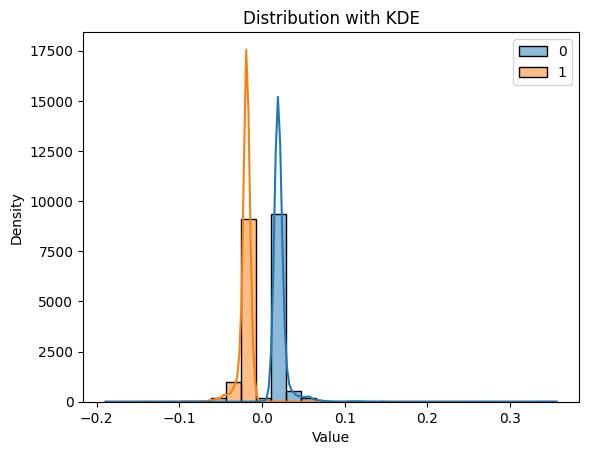

In [6]:
distribution(predictions)

In [33]:
# Make predictions
predictions = model.predict(X_test)

# Extract actual mix and max percentage changes
actual_max = [pair[0] for pair in y_test]
actual_min = [pair[1] for pair in y_test]

# Extract predicted max and min percentage changes
predicted_max = predictions[:, 0]
predicted_min = predictions[:, 1]

max_difference = actual_max - predicted_max


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


In [ ]:
import matplotlib.pyplot as plt # This sets the appropriate backend for Jupyter notebooks


import numpy as np

cut = 25
max_difference_cut = [max_difference[i]*100 for i in range(len(max_difference)) if i % cut == 0]

# max cuts
predicted_max_cut = [predicted_max[i]*100 for i in range(len(predicted_max)) if i % cut == 0]
actual_max_cut = [actual_max[i]*100 for i in range(len(actual_max)) if i % cut == 0]

# min cuts
predicted_min_cut = [predicted_min[i]*100 for i in range(len(predicted_min)) if i % cut == 0]
actual_min_cut = [actual_min[i]*100 for i in range(len(actual_min)) if i % cut == 0]

#df = pd.DataFrame(X_test)
#y_test = df.iloc[:, 2].to_numpy()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Size of the figure
#plt.plot(max_difference_25, label='Variation', color='green')  # Plot actual values
plt.plot(actual_max_cut, label='Actual', color='red')  # Plot actual values
plt.plot(predicted_max_cut, label='Predicted', color='blue')  # Plot predicted values

# Add labels and title
plt.xlabel('Index')  # You can also use time or other labels
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'max_difference' is not defined